In [ ]:
import os
import re
import sklearn
import numpy as np
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor, BaggingClassifier, AdaBoostClassifier, VotingClassifier, VotingRegressor
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn import svm
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy import sparse
from tqdm import tqdm_notebook
from nltk import word_tokenize
from pymagnitude import *
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.naive_bayes import BernoulliNB
import pandas as pd
from sklearn.model_selection import train_test_split
from gensim.models import Doc2Vec

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pymagnitude

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.4 MB 9.9 MB/s 
  Created wheel for pymagnitude: filename=pymagnitude-0.1.143-cp37-cp37m-linux_x86_64.whl size=360425724 sha256=d716ae6af420f96db3b82d5d9e006f5250a091168d9d43d18f626fe80f0ca17a
  Stored in directory: /root/.cache/pip/wheels/0e/96/d6/b765a1ce34517c193d764b634b1ff7db5e1dcfea2520f17273
Successfully built pymagnitude


In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score

import matplotlib
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight

from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns


from itertools import product

# Classification

In [ ]:
ad_dict = {'NON-AD': 0,
                'AD': 1}

ad_keys = list(['NON-AD', 'AD'])


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def one_hot_encoder(true_labels, num_records, num_classes):
    temp = np.array(true_labels[:num_records])
    true_labels = np.zeros((num_records, num_classes))
    true_labels[np.arange(num_records), temp] = 1
    return true_labels

def display_results(y_test, pred, cm=True):
    print('Test Set Accuracy =  {0:.3f}'.format(accuracy_score(y_test, pred)))
    print('Test Set F1-score =  {0:.3f}'.format(f1_score(y_test, pred, average='macro')))
    print('Test Set Precision =  {0:.3f}'.format(precision_score(y_test, pred, average='macro')))
    print('Test Set Recall =  {0:.3f}'.format(recall_score(y_test, pred, average='macro')))
    if cm:
        plot_confusion_matrix(confusion_matrix(y_test, pred), classes=ad_keys)

# Embedding models

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/train108mmse.csv').sample(frac=1)
test = pd.read_csv('/content/drive/MyDrive/test108crct.csv')

X_train_original = np.array(df['doc_text'])
y_train_original = np.array(df['labels'])
y_train_original_mmse = np.array(df['mmse'])

X_test_original = np.array(test['doc_text'])
test_ids = np.array(test['ID'])

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/test108crct.csv')
y_test_ori=np.array(test['labels'])

In [ ]:
y_test_ori

array([0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 1, 0, 0])

In [ ]:
y_test_ori=[0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 1, 0, 0]

In [ ]:
#word2vec
len(y_test_ori)


48

In [ ]:

#!curl -s http://magnitude.plasticity.ai/glove+subword/glove.6B.50d.magnitude --output vectors.magnitude
!curl -s http://magnitude.plasticity.ai/word2vec+subword/GoogleNews-vectors-negative300.magnitude --output word2vec.magnitude
!curl -s http://magnitude.plasticity.ai/fasttext+subword/wiki-news-300d-1M.magnitude --output fasttext.magnitude

!curl -s http://magnitude.plasticity.ai/glove+subword/glove.6B.100d.magnitude --output glovevectors.magnitude

In [ ]:
#word2vec
from tqdm import tqdm_notebook
from nltk import word_tokenize
from pymagnitude import *
w2v = Magnitude("/content/word2vec.magnitude")
def avg_w2v(x):
    vectors = []
    for title in tqdm_notebook(x):
        vectors.append(np.average(w2v.query(word_tokenize(title)), axis = 0))
    return np.array(vectors)

X_train = avg_w2v(X_train_original)
y_train = y_train_original
X_test = avg_w2v(X_test_original)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
clf_final = RandomForestClassifier(n_estimators=10000,n_jobs=-1)
clf_final.fit(X_train, y_train)
y_pred = clf_final.predict(X_test)
print(y_pred)
print(sum(y_pred))
result = pd.DataFrame(data = {'ID':test_ids, 'Prediction':y_pred})
result.to_csv('/content/drive/MyDrive/linguistic_results/test_results-classif-word2vec-rf.txt', index=False, sep=';')

clf_final = MLPClassifier(n_iter_no_change=50, max_iter=10000,hidden_layer_sizes=(1024, ))
clf_final.fit(X_train, y_train)
y_pred = clf_final.predict(X_test)
print(y_pred)
print(sum(y_pred))
result = pd.DataFrame(data = {'ID':test_ids, 'Prediction':y_pred})
result.to_csv('/content/drive/MyDrive/linguistic_results/test_results-classif-word2vec-mlp.txt', index=False, sep=';')

[0 0 0 0 1 1 0 1 0 0 1 1 0 0 0 1 1 0 0 1 0 1 1 0 0 1 0 1 1 0 1 1 1 0 1 1 0
 1 0 0 1 0 0 1 0 0 0 0]
21
[0 0 0 0 1 1 0 0 0 0 1 1 0 1 0 1 1 0 0 1 0 1 1 0 0 1 0 1 1 1 1 1 1 0 1 0 0
 1 0 0 1 0 0 1 0 0 0 0]
21


Test Set Accuracy =  0.771
Test Set F1-score =  0.770
Test Set Precision =  0.775
Test Set Recall =  0.771
Confusion matrix
[[20  4]
 [ 7 17]]


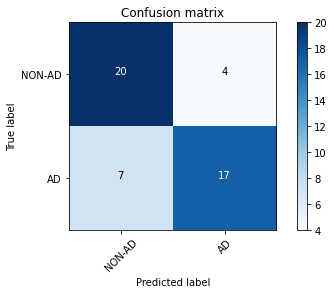

In [ ]:
#word2vec-classification-rf
y_pred=[0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0,
 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]
display_results(y_test_ori,y_pred)

Test Set Accuracy =  0.771
Test Set F1-score =  0.770
Test Set Precision =  0.775
Test Set Recall =  0.771
Confusion matrix
[[20  4]
 [ 7 17]]


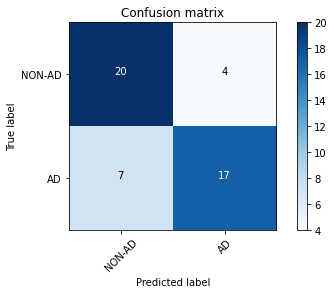

In [ ]:
#word2vec-classification-mlp
import numpy as np
y_pred=[0 ,0 ,0 ,0 ,1, 1, 0 ,0 ,0 ,0 ,1 ,1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0,
 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]
display_results(y_test_ori,y_pred)

In [ ]:
#glove
from tqdm import tqdm_notebook
from nltk import word_tokenize
from pymagnitude import *


glove = Magnitude("/content/glovevectors.magnitude")
def avg_glove(x):
    vectors = []
    for title in tqdm_notebook(x):
        vectors.append(np.average(glove.query(word_tokenize(title)), axis = 0))
    return np.array(vectors)

X_train = avg_glove(X_train_original)
y_train = y_train_original

X_test = avg_glove(X_test_original)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

In [ ]:

clf_final = RandomForestClassifier(n_estimators=10000,n_jobs=-1)
clf_final.fit(X_train, y_train)
y_pred = clf_final.predict(X_test)
print(y_pred)
print(sum(y_pred))
result = pd.DataFrame(data = {'ID':test_ids, 'Prediction':y_pred})
result.to_csv('/content/drive/MyDrive/linguistic_results/test_results-classif-glove-rf.txt', index=False, sep=';')

clf_final = MLPClassifier(n_iter_no_change=50, max_iter=10000,hidden_layer_sizes=(1024, ))
clf_final.fit(X_train, y_train)
y_pred = clf_final.predict(X_test)
print(y_pred)
print(sum(y_pred))
result = pd.DataFrame(data = {'ID':test_ids, 'Prediction':y_pred})
result.to_csv('/content/drive/MyDrive/linguistic_results/test_results-classif-glove-mlp.txt', index=False, sep=';')

[0 0 0 0 1 1 0 1 0 0 1 1 0 0 0 1 1 0 0 1 0 1 0 0 0 1 0 1 1 1 1 1 1 0 1 0 0
 0 0 0 1 0 0 1 0 0 0 0]
19
[0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 1 1 0 0 1 0 1 1 0 0 1 0 1 1 1 1 1 1 0 1 0 0
 1 0 0 1 0 0 1 0 0 0 0]
20


Test Set Accuracy =  0.771
Test Set F1-score =  0.768
Test Set Precision =  0.783
Test Set Recall =  0.771
Confusion matrix
[[21  3]
 [ 8 16]]


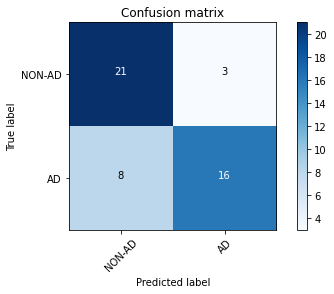

In [ ]:
#glove-classification-rf
y_pred=[0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0,
 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]
display_results(y_test_ori,y_pred)

Test Set Accuracy =  0.771
Test Set F1-score =  0.768
Test Set Precision =  0.783
Test Set Recall =  0.771
Confusion matrix
[[21  3]
 [ 8 16]]


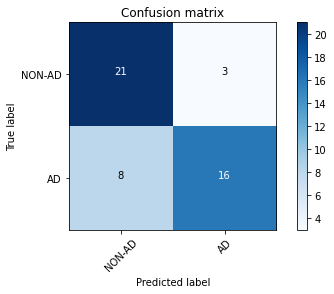

In [ ]:
#glove-classification-mlp
y_pred=[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0 ,1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1 ,1, 1, 0, 1, 0, 0,
 1, 0, 0, 1 ,0 ,0 ,1 ,0, 0, 0, 0]
display_results(y_test_ori,y_pred)

In [ ]:
#fasttext
from tqdm import tqdm_notebook
from nltk import word_tokenize
from pymagnitude import *


glove = Magnitude("/content/fasttext.magnitude")
def avg_glove(x):
    vectors = []
    for title in tqdm_notebook(x):
        vectors.append(np.average(glove.query(word_tokenize(title)), axis = 0))
    return np.array(vectors)

X_train = avg_glove(X_train_original)
y_train = y_train_original
X_test = avg_glove(X_test_original)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

In [ ]:
clf_final = RandomForestClassifier(n_estimators=10000,n_jobs=-1)
clf_final.fit(X_train, y_train)
y_pred = clf_final.predict(X_test)
print(y_pred)
print(sum(y_pred))
result = pd.DataFrame(data = {'ID':test_ids, 'Prediction':y_pred})
result.to_csv('/content/drive/MyDrive/linguistic_results/test_results-classif-fasttext-rf.txt', index=False, sep=';')

clf_final = MLPClassifier(n_iter_no_change=50, max_iter=10000,hidden_layer_sizes=(1024, ))
clf_final.fit(X_train, y_train)
y_pred = clf_final.predict(X_test)
print(y_pred)
print(sum(y_pred))
result = pd.DataFrame(data = {'ID':test_ids, 'Prediction':y_pred})
result.to_csv('/content/drive/MyDrive/linguistic_results/test_results-classif-fasttext-mlp.txt', index=False, sep=';')

[0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 1 1 0 0 1 0 1 1 0 0 1 0 1 1 0 1 1 1 0 1 0 0
 0 0 0 1 0 0 1 0 0 0 0]
18
[0 0 0 0 1 1 0 0 0 0 1 1 0 1 0 1 1 0 0 1 0 1 1 0 0 1 0 1 1 1 1 1 1 0 1 1 0
 1 0 0 1 0 0 1 0 0 0 0]
22


Test Set Accuracy =  0.771
Test Set F1-score =  0.766
Test Set Precision =  0.796
Test Set Recall =  0.771
Confusion matrix
[[22  2]
 [ 9 15]]


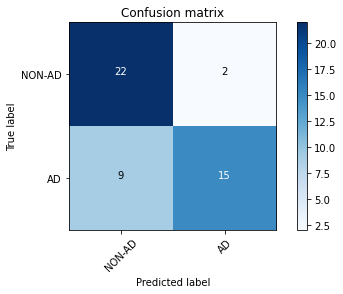

In [ ]:
#fasttext-classification-rf
y_pred=[0, 0, 0 ,0 ,0, 1, 0, 0, 0 ,0 ,1 ,1, 0, 0 ,0 ,1 ,1 ,0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0,
 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]
display_results(y_test_ori,y_pred)

Test Set Accuracy =  0.792
Test Set F1-score =  0.791
Test Set Precision =  0.794
Test Set Recall =  0.792
Confusion matrix
[[20  4]
 [ 6 18]]


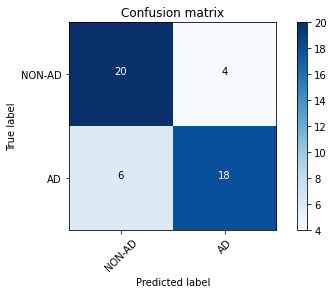

In [ ]:
#fasttext-classification-mlp
y_pred=[0, 0 ,0 ,0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1 ,1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0
 ,1 ,0 ,0 ,1 ,0 ,0 ,1 ,0 ,0, 0, 0]
display_results(y_test_ori,y_pred)

# Regression

# Embedding 

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/train108mmse.csv').sample(frac=1)
test = pd.read_csv('/content/drive/MyDrive/test108crct.csv')

X_train_original = np.array(df['whole_text'])
y_train_original = np.array(df['labels'])
y_train_original_mmse = np.array(df['mmse'])

X_test_original = np.array(test['whole_text'])
test_ids = np.array(test['ID'])

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/test108crct.csv')
y_test_ori_mmse=np.array(test['mmse'])

In [ ]:
y_test_ori_mmse

array([28, 29, 24, 30, 21, 15, 29, 28, 27, 26, 28, 23, 30, 17, 29, 30, 27,
       30, 30, 10, 29, 17, 12, 30, 29, 19, 29, 18, 20, 20, 13, 22, 12, 24,
       11, 26, 30, 28, 19, 30, 25, 30, 30, 18, 28, 23, 28, 27])

In [ ]:
#word2vec
from tqdm import tqdm_notebook
from nltk import word_tokenize
from pymagnitude import *
glove = Magnitude("/content/word2vec.magnitude")
def avg_glove(x):
    vectors = []
    for title in tqdm_notebook(x):
        vectors.append(np.average(glove.query(word_tokenize(title)), axis = 0))
    return np.array(vectors)

X_train = avg_glove(X_train_original)
y_train = y_train_original_mmse
X_test = avg_glove(X_test_original)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

In [ ]:
clf_final = RandomForestClassifier(n_estimators=10000,n_jobs=-1)
clf_final.fit(X_train, y_train)
y_pred = clf_final.predict(X_test)
result = pd.DataFrame(data = {'ID':test_ids, 'Prediction':y_pred})
result.to_csv('/content/drive/MyDrive/linguistic_results/results-reg-word2vec-rf.txt', index=False, sep=';')

clf_final = MLPClassifier(n_iter_no_change=50, max_iter=10000,hidden_layer_sizes=(1024, ))
clf_final.fit(X_train, y_train)
y_pred = clf_final.predict(X_test)
result = pd.DataFrame(data = {'ID':test_ids, 'Prediction':y_pred})
result.to_csv('/content/drive/MyDrive/linguistic_results/results-reg-word2vec-mlp.txt', index=False, sep=';')

In [ ]:
#word2vec-rf
from sklearn.metrics import mean_squared_error
y_pred=[27.5906, 27.3837, 26.2855 ,27.1365, 23.5689 ,12.8988, 27.3867, 25.7821, 26.6929,
 22.934  ,22.0141, 16.6269, 25.2709 ,26.9064, 26.9493 ,21.4455, 20.1988, 27.4922,
 28.017  ,17.0884, 27.7504, 16.3832 ,19.1535, 28.3924 ,28.7536 ,26.0607 ,27.7542,
 18.8937 ,21.3126, 26.8994, 16.994 , 19.1256, 16.126 , 28.7404 ,21.2021, 21.1981,
 26.841  ,24.7761 ,22.6709, 28.5463, 22.2349, 24.5876, 20.4805 ,23.319,  27.6257,
 24.7043, 28.0946, 21.4652]
print("RMSE : ",np.sqrt(mean_squared_error(y_test_ori_mmse,y_pred)))

RMSE : 4.96191476712356


In [ ]:
#word2vec-mlp
y_pred=[14.158114, 28.46104,  27.685087 ,30.460623, 19.866793 , 8.616202, 28.990328,
 24.29187  ,20.543367 ,27.367685 ,14.358371 ,18.049282, 32.38862  ,23.842165,
 31.117922 ,19.829065, 18.423084 ,32.36314 , 29.942392 ,13.686542 ,28.517992,
 14.135432 ,16.867186, 35.765312 ,25.87676 , 26.664492 ,28.209455 ,17.303465,
 26.11233  ,26.437548 ,14.529404 ,12.906272, 13.918918 ,27.555094 ,26.869556,
 28.522913 ,30.56963 , 18.838238 ,30.848085, 25.450508 ,24.947634, 21.39205,
 21.972914 ,19.722017 ,22.087065 ,22.123934, 30.955927 ,33.882977]
print("RMSE : ",np.sqrt(mean_squared_error(y_test_ori_mmse,y_pred)))

RMSE :  6.159084743113812


In [ ]:
#glove
from tqdm import tqdm_notebook
from nltk import word_tokenize
from pymagnitude import *


glove = Magnitude("/content/glovevectors.magnitude")
def avg_glove(x):
    vectors = []
    for title in tqdm_notebook(x):
        vectors.append(np.average(glove.query(word_tokenize(title)), axis = 0))
    return np.array(vectors)

X_train = avg_glove(X_train_original)
y_train = y_train_original_mmse

X_test = avg_glove(X_test_original)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

In [ ]:
clf_final = RandomForestClassifier(n_estimators=10000,n_jobs=-1)
clf_final.fit(X_train, y_train)
y_pred = clf_final.predict(X_test)
result = pd.DataFrame(data = {'ID':test_ids, 'Prediction':y_pred})
result.to_csv('/content/drive/MyDrive/linguistic_results/results-reg-glove-rf.txt', index=False, sep=';')

clf_final = MLPClassifier(n_iter_no_change=50, max_iter=10000,hidden_layer_sizes=(1024, ))
clf_final.fit(X_train, y_train)
y_pred = clf_final.predict(X_test)
result = pd.DataFrame(data = {'ID':test_ids, 'Prediction':y_pred})
result.to_csv('/content/drive/MyDrive/linguistic_results/results-reg-glove-mlp.txt', index=False, sep=';')

In [ ]:
#glove-rf
from sklearn.metrics import mean_squared_error
y_pred=[27.0894, 28.1958, 26.3906 ,28.5131, 22.9338 ,13.5924, 28.2537 ,27.5645, 26.8434,
 26.3391 ,25.506 , 16.3609, 27.5534, 27.2179, 27.6817, 22.3625, 19.2266 ,26.975,
 29.087  ,16.7279, 28.3442, 17.8385, 20.8558, 28.9762, 29.0708, 24.8613 ,28.5184,
 19.9257 ,18.0484, 27.3861, 16.7442 ,20.128 , 16.8876, 28.9423, 22.9687 ,23.9267,
 27.3205 ,24.5927 ,22.2503, 27.7828, 23.1169, 26.878,  22.5943 ,23.047 , 27.2438,
 26.6962 ,27.9327, 24.5119]
print("RMSE : ",np.sqrt(mean_squared_error(y_test_ori_mmse,y_pred)))

RMSE : 5.309404959673473


In [ ]:
#glove-mlp 
from sklearn.metrics import mean_squared_error
y_pred=[28.06533,  30.270039, 28.995909, 28.984148, 15.826069  ,8.018259 ,25.693825,
 20.265053, 32.580017, 28.837435, 15.541461, 33.58045,  30.101528, 27.941954,
 40.913643, 20.579027, 20.962187, 33.102226, 45.503376, 29.482992, 22.52004,
 13.516001, 25.735273, 37.05872,  30.901575, 23.530073, 43.42147 , 21.43492,
 20.651693, 23.249132, 19.90694 , 25.568325, 19.713354, 28.449104, 21.521893,
 27.840115, 40.34928,  32.814514 ,25.004084, 24.84354 , 16.352297 ,24.056585,
 28.174105, 14.724295, 30.072638, 28.092667, 35.640614, 30.319246]

#glove-mlp 
print("RMSE : ",np.sqrt(mean_squared_error(y_test_ori_mmse,y_pred)))

RMSE :  7.520438260779821


In [ ]:
#fasttext
from tqdm import tqdm_notebook
from nltk import word_tokenize
from pymagnitude import *


glove = Magnitude("/content/fasttext.magnitude")
def avg_glove(x):
    vectors = []
    for title in tqdm_notebook(x):
        vectors.append(np.average(glove.query(word_tokenize(title)), axis = 0))
    return np.array(vectors)

X_train = avg_glove(X_train_original)
y = y_train_original_mmse
X_test = avg_glove(X_test_original)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

In [ ]:
clf_final = RandomForestClassifier(n_estimators=10000,n_jobs=-1)
clf_final.fit(X_train, y_train)
y_pred = clf_final.predict(X_test)
result = pd.DataFrame(data = {'ID':test_ids, 'Prediction':y_pred})
result.to_csv('/content/drive/MyDrive/linguistic_results/results-reg-fasttext-rf.txt', index=False, sep=';')

clf_final = MLPClassifier(n_iter_no_change=50, max_iter=10000,hidden_layer_sizes=(1024, ))
clf_final.fit(X_train, y_train)
y_pred = clf_final.predict(X_test)
result = pd.DataFrame(data = {'ID':test_ids, 'Prediction':y_pred})
result.to_csv('/content/drive/MyDrive/linguistic_results/results-reg-fasttext-mlp.txt', index=False, sep=';')

In [ ]:
#fasttext-rf
from sklearn.metrics import mean_squared_error
y_pred=[27.5445, 27.8112, 27.1937 ,28.0812, 22.9857, 12.1219 ,27.9295 ,22.8637, 25.5036,
 25.6628, 23.1491, 22.0205, 27.5267, 27.3133, 28.2341, 25.5487, 19.1686 ,26.8848,
 28.7555 ,23.2637, 26.4322, 16.87  , 19.8536, 28.9172, 28.5102, 23.7468 ,28.5836,
 20.5571 ,22.1624, 26.1945, 18.0139 ,22.7884, 15.5864, 28.4718, 20.5138, 27.0222,
 25.7796 ,21.7184, 23.4235, 26.9745 ,23.9642 ,25.5533, 25.6853 ,23.8475 ,26.2983,
 25.4691 ,28.0163, 25.838 ]

#fasttext-rf 
print("RMSE : ",np.sqrt(mean_squared_error(y_test_ori_mmse,y_pred)))

RMSE : 4.991404677439972


In [ ]:
#fasttext-mlp
from sklearn.metrics import mean_squared_error
y_pred=[25.636288 , 26.021118,  27.149174 , 24.099953 , 23.563118  , 7.011812,
 31.280987  ,24.62038  , 23.9277   , 26.803278,  21.048798 , 19.092062,
 32.408424 , 29.96267  , 33.19467  , 19.532246 , 14.586357 , 35.092644,
 34.233765 , 13.437862 , 32.476326 , 14.8972645, 18.997944 , 32.760517,
 26.83975  , 22.776173 , 35.02736  , 14.963173 , 22.265442 , 20.089174,
  9.213226 , 15.544865 ,  8.447807 , 28.580967 , 15.08864  , 25.726746,
 32.695827 , 21.235905  ,23.632713 , 25.76966,   21.065641 , 19.88612,
 22.300861,  14.741564  ,28.400455,  20.516151,  35.982807 , 28.674492 ]

#fasttext-mlp 
print("RMSE : ",np.sqrt(mean_squared_error(y_test_ori_mmse,y_pred)))

RMSE :  5.269146890945762
